This notebook is used to download image cutouts locally to be used for Model training and validation.

Warning: some code blocks in this notebook download over 1,000 images. Those poritons have been commented out to ensure no accidental downloads. 

In [ ]:
# packages needed to for file management,
# downloading and unpacking compressed catalogs.

from urllib3 import PoolManager


# basic packages for data handling and plotting
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

from astropy.io import fits
from astropy.table import Table

from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats

from scipy.constants import c as speed_of_light

# we download a file with multiple helpfull methods from the same git repository.
# These functions are well documented to facilitate further reading.
helper_func_url = 'https://raw.githubusercontent.com/DanielMaschmann/PHANGS_HST_star_cluster/main/helper_func.py'
# Download file. This will save them in the working directory.
http = PoolManager()
http_request_object = http.request('GET', helper_func_url, preload_content=False)
with open('helper_func.py', 'wb') as out:
    while True:
        data = http_request_object.read()
        if not data:
            break
        out.write(data)

!pip install dust_extinction

# in case of updates
%load_ext autoreload
%autoreload 2
import importlib
import helper_func as helper_func
mylibrary = importlib.reload(helper_func)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# we use NGC ngc1097 as an example
galaxy_name = 'ngc1097'

In [48]:
# some galaxies have HST image mosaics. Therefore the file names can change!
mosaic_flag = True
if mosaic_flag:
  bundle_file_name = galaxy_name + 'mosaic'
else:
  bundle_file_name = galaxy_name

In [49]:
fits_table = Table.read('../data/valid_detections.fits')
fits_table

INDEX,ID_PHANGS_CLUSTER,ID_PHANGS_CANDIDATE,ID_PHANGS_ALLSOURCES,PHANGS_X,PHANGS_Y,PHANGS_RA,PHANGS_DEC,PHANGS_GALAXY,PHANGS_DM_1,PHANGS_DMPC_1,PHANGS_DERR_1,PHANGS_CLUSTER_CLASS_HUMAN,PHANGS_CLUSTER_CLASS_ML_VGG,PHANGS_CLUSTER_CLASS_ML_VGG_QUAL,PHANGS_CLUSTER_CLASS_ML_VGG_CORR
,,,,,,deg,deg,,,,,,,,
int64,int64,int64,int64,float64,float64,float64,float64,bytes7,float64,float64,float64,float64,int64,float64,int64
5,-999,5,1813,4975.44,1940.57,41.59600896122001,-30.322652612237484,ngc1097,30.664498849722413,13.58,2.04,9.0,9,0.7,9
26,-999,26,654,5441.44,2110.12,41.59006743234052,-30.32078707718581,ngc1097,30.664498849722413,13.58,2.04,9.0,9,0.9,9
38,19,38,5602,4801.12,2219.94,41.59823102243026,-30.3195777525278,ngc1097,30.664498849722413,13.58,2.04,1.0,1,1.0,1
52,25,52,3285,5384.11,2276.07,41.59079821677067,-30.31896066464826,ngc1097,30.664498849722413,13.58,2.04,3.0,2,0.7,2
59,28,59,1211,5385.52,2284.88,41.59078023253215,-30.318863706825663,ngc1097,30.664498849722413,13.58,2.04,2.0,2,1.0,2
79,39,79,4435,5328.34,2323.84,41.591509198913045,-30.31843488517973,ngc1097,30.664498849722413,13.58,2.04,2.0,2,1.0,2
99,-999,99,6097,4987.59,2381.69,41.59585341300243,-30.317797859628545,ngc1097,30.664498849722413,13.58,2.04,5.0,5,0.9,5
114,-999,114,8021,5149.72,2422.29,41.5937863455209,-30.317351220857812,ngc1097,30.664498849722413,13.58,2.04,5.0,5,1.0,5


In [ ]:
def get_unique_labels(fits_table, column_name='PHANGS_CLUSTER_CLASS_HUMAN'):

    # Open the FITS file and load the data
    with fits.open(fits_table) as hdul:
        data = hdul[1].data  # Usually, tables are in the first extension (hdul[1])

    # Extract the relevant column safely
    labels = data[column_name]

    # Get unique labels
    unique_labels = list(set(labels))

    return unique_labels

# Example usage
fits_file = "../data/valid_detections.fits"
unique_labels = get_unique_labels(fits_file)
print(unique_labels)


[np.float64(1.0), np.float64(2.0), np.float64(3.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(9.0), np.float64(10.0), np.float64(13.0), np.float64(15.0), np.float64(16.0), np.float64(19.0)]


In [51]:
# get all data we need for the following examples
# coordinates
ra_hum_cl, dec_hum_cl = fits_table['PHANGS_RA'], fits_table['PHANGS_DEC']

# morphological classification
class_human_hum_cl = fits_table['PHANGS_CLUSTER_CLASS_HUMAN']

In [52]:
# load the downloaded images
v_band_img_hdu = fits.open('%s/hlsp_phangs-hst_hst_wfc3-uvis_%s_f555w_v1_exp-drc-sci.fits' % (bundle_file_name, bundle_file_name))
v_band_img_header = v_band_img_hdu[0].header
v_band_img_data = v_band_img_hdu[0].data
v_band_img_wcs = WCS(v_band_img_header)

# change the image data from electron counts to units of Jy
# wavelength in angstrom
pivot_wavelength = v_band_img_header['PHOTPLAM']
# inverse sensitivity, ergs/cm2/Ang/electron
sensitivity = v_band_img_header['PHOTFLAM']
# speed of light in Angstrom/s
c = speed_of_light * 1e10
# change the conversion facto to get erg s−1 cm−2 Hz−1
f_nu = sensitivity * pivot_wavelength ** 2 / c
# change to get Jy
conversion_factor = f_nu * 1e23
# apply the conversion factor to the data
v_band_img_data *= conversion_factor

# this is not used in this tutorial but for completeness here we will load the uncertainty maps
v_band_invers_var_hdu = fits.open('%s/hlsp_phangs-hst_hst_wfc3-uvis_%s_f555w_v1_err-drc-wht.fits' % (bundle_file_name, bundle_file_name))
v_band_invers_var_data = v_band_invers_var_hdu[0].data
# the uncertainties are stored as inverse variance so we need to convert them into the standard deviation.
v_band_err_data = 1 / np.sqrt(v_band_invers_var_data)
# and again we need to apply the conversion factor to these data
v_band_err_data *= conversion_factor



C:\Users\SEANM\AppData\Local\Temp\ipykernel_18704\3871222887.py:25: RuntimeWarning: divide by zero encountered in divide
  v_band_err_data = 1 / np.sqrt(v_band_invers_var_data)


In [53]:
# in order to visualize the image we calculate some states of the image and calculate a strech.
mean, median, std = sigma_clipped_stats(v_band_img_data, sigma=3.0)
norm = LogNorm(0.1*std, median + 100*std)

coords_hum_cl = SkyCoord(ra=ra_hum_cl, dec=dec_hum_cl)
coords_hum_cl_pix = v_band_img_wcs.world_to_pixel(coords_hum_cl)


In [54]:
# cutout of random class 1, 2, 3 clusters
mask_class1 = class_human_hum_cl == 1
mask_class2 = class_human_hum_cl == 2
mask_class3 = class_human_hum_cl == 3
mask_class4 = class_human_hum_cl == 4
mask_class5 = class_human_hum_cl == 5
mask_class6 = class_human_hum_cl == 6
mask_class7 = class_human_hum_cl == 7
mask_class8 = class_human_hum_cl == 8
mask_class9 = class_human_hum_cl == 9
mask_class10 = class_human_hum_cl == 10

mask_class13 = class_human_hum_cl == 13

mask_class15 = class_human_hum_cl == 15
mask_class16 = class_human_hum_cl == 16

mask_class19 = class_human_hum_cl == 19

coord_bright_class1 = coords_hum_cl[mask_class1][101]
coord_bright_class2 = coords_hum_cl[mask_class2][13]
coord_bright_class3 = coords_hum_cl[mask_class3][1]
coord_bright_class4 = coords_hum_cl[mask_class4][0]


cutout_bright_class1 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class1,
                                                  cutout_size=(2, 2))
cutout_bright_class2 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class2,
                                                  cutout_size=(2, 2))
cutout_bright_class3 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class3,
                                                  cutout_size=(2, 2))
cutout_bright_class4 = helper_func.get_img_cutout(img=v_band_img_data,
                                                  wcs=v_band_img_wcs,
                                                  coord=coord_bright_class4,
                                                  cutout_size=(2, 2))

def get_coords(class_num):

    mask_class = class_human_hum_cl == class_num

    coord_bright_class = coords_hum_cl[mask_class]

    cutouts_class = [
        helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coords_bright_class[i], cutout_size=(2, 2))
    ]

In [55]:
def get_class_cutouts(class_num, cutout_size=(2, 2)):

    mask_class = class_human_hum_cl == class_num

    # Get the coordinates for the given class
    coords_bright_class = coords_hum_cl[mask_class]

    # Extract cutouts for the class
    cutouts_class = []
    for coord in coords_bright_class:
        cutout = helper_func.get_img_cutout(img=v_band_img_data, wcs=v_band_img_wcs, coord=coord, cutout_size=cutout_size)
        cutouts_class.append(cutout)

    return cutouts_class




Text(0.5, 1.0, 'Class 4')

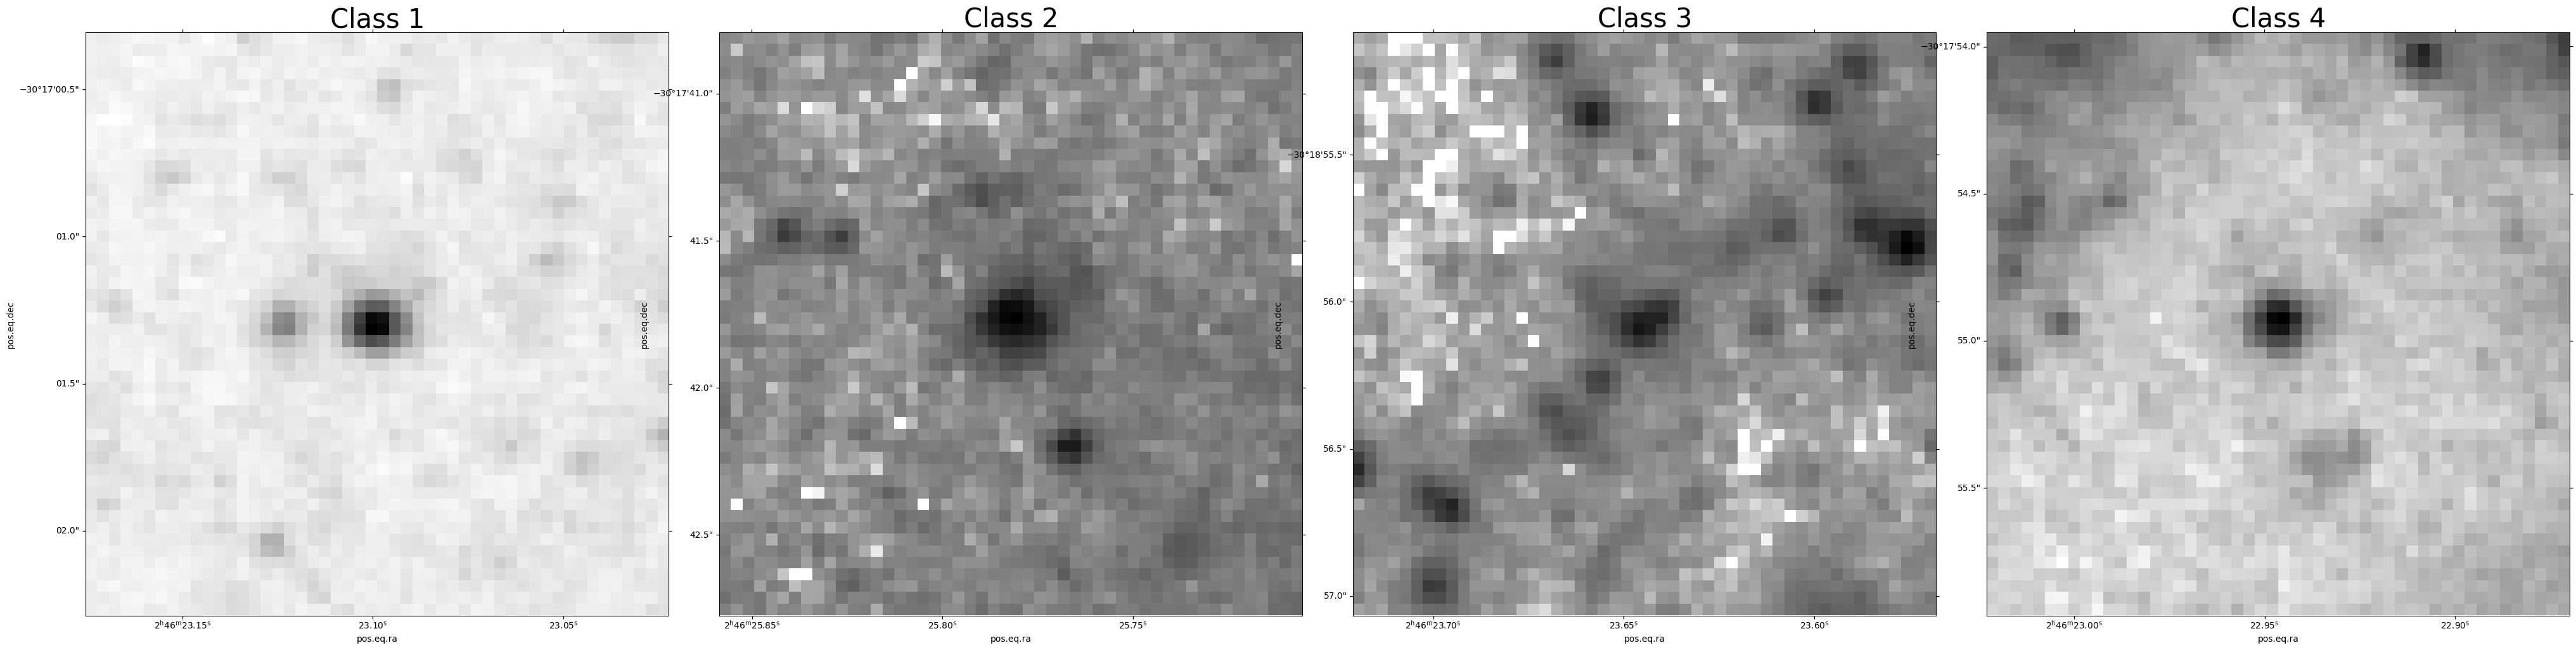

In [56]:

figure_cutouts = plt.figure(figsize=(40, 10))

ax_cutout_class1 = figure_cutouts.add_axes([0.01, 0.05, 0.23, 0.94], projection=cutout_bright_class1.wcs)
ax_cutout_class2 = figure_cutouts.add_axes([0.26, 0.05, 0.23, 0.94], projection=cutout_bright_class2.wcs)
ax_cutout_class3 = figure_cutouts.add_axes([0.51, 0.05, 0.23, 0.94], projection=cutout_bright_class3.wcs)
ax_cutout_class4 = figure_cutouts.add_axes([0.76, 0.05, 0.23, 0.94], projection=cutout_bright_class4.wcs)

ax_cutout_class1.imshow(cutout_bright_class1.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class2.imshow(cutout_bright_class2.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class3.imshow(cutout_bright_class3.data, norm=LogNorm(), cmap='Greys')
ax_cutout_class4.imshow(cutout_bright_class4.data, norm=LogNorm(), cmap='Greys')

ax_cutout_class1.set_title('Class 1', fontsize=30)
ax_cutout_class2.set_title('Class 2', fontsize=30)
ax_cutout_class3.set_title('Class 3', fontsize=30)
ax_cutout_class4.set_title('Class 4', fontsize=30)

This code downloads all images from the data set into a folder named cutouts_png.

In [ ]:
"""
def save_cutouts_as_png(class_num):

    # Create output directory if it doesn't exist
    output_dir = "../data/cutout_pngs"
    class_output_dir = os.path.join(output_dir, str(class_num))
    if not os.path.exists(class_output_dir):
        os.makedirs(class_output_dir)

    # Get cutouts for each coordinate using your working method (assuming it's called get_cutouts)
    cutouts = get_class_cutouts(class_num)

    # Iterate through the cutouts and save them as PNG
    for idx, cutout in enumerate(cutouts):
        if cutout is None or cutout.data is None:
            print(f"Warning: No data found for cutout {idx + 1} for class {class_num}. Skipping.")
            continue

        # Create a filename for each image
        filename = os.path.join(class_output_dir, f"class_{class_num}_cutout_{idx + 1}.png")

        # Plot the cutout image and save it
        plt.figure(figsize=(5, 5))  # Create a new figure for each image
        plt.imshow(cutout.data, cmap='gray', origin='lower')
        plt.axis('off')  # Hide axes

        plt.savefig(filename, bbox_inches='tight', pad_inches=0)
        plt.close() # Close the current figure, and clear its memory.

# Example usage
for i in unique_labels:

    save_cutouts_as_png(i)
"""

This code creates a stratified split of training and validation data sets from the previously downloaded images.

In [ ]:
"""
import os
import shutil
from sklearn.model_selection import train_test_split

# Define the root directory where the class folders are stored
root_dir = "../data/cutout_pngs"  # Change to your folder path
train_dir = "../data/train_pngs"  # Directory to store training data
test_dir = "../data/test_pngs"    # Directory to store test data

# Prepare the data: Gather image file paths and their corresponding class labels
image_paths = []
labels = []

# Iterate through each class folder
for class_num in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_num)
    if os.path.isdir(class_path):  # Make sure it's a directory
        for img_file in os.listdir(class_path):
            if img_file.endswith('.png'):
                img_path = os.path.join(class_path, img_file)
                image_paths.append(img_path)
                labels.append(class_num)  # Class label is the folder name

# Perform stratified split: 80% train, 20% test
train_images, test_images, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

# Create the directories for train/test splits
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Now, create subdirectories for each class in the train and test directories
for class_num in set(labels):  # For each unique class
    os.makedirs(os.path.join(train_dir, class_num), exist_ok=True)
    os.makedirs(os.path.join(test_dir, class_num), exist_ok=True)

# Function to move images to the appropriate directories
def move_images(image_list, target_dir, labels):
    for img, label in zip(image_list, labels):
        target_path = os.path.join(target_dir, label, os.path.basename(img))
        shutil.copy(img, target_path)

# Move training images
move_images(train_images, train_dir, train_labels)

# Move testing images
move_images(test_images, test_dir, test_labels)

print("Data split into training and test sets successfully!")
"""

Data split into training and test sets successfully!
